In [ ]:
import os.path
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from scipy.fft import fft

file_name = '/kaggle/input/eye-state-classification-eeg-dataset/EEG Eye State.arff'

data, meta = arff.loadarff(file_name)
data = pd.DataFrame(data)
data["eyeDetection"] = data["eyeDetection"].astype('int')
data.describe()

factorContaminacion = 0.5/100

rng = np.random.RandomState(42)

cOneClassSVM = svm.OneClassSVM(nu=1 - factorContaminacion, kernel="rbf", gamma=0.1)
cIsolationForest = IsolationForest(contamination=factorContaminacion, random_state=rng, n_jobs=-1)
cLocalOutlierFactor = LocalOutlierFactor(n_neighbors=35, contamination=factorContaminacion, n_jobs=-1)

cOneClassSVM.fit(X=data)
cIsolationForest.fit(X=data)
esOutlier = np.column_stack((cOneClassSVM.predict(X=data), cIsolationForest.predict(X=data), cLocalOutlierFactor.fit_predict(X=data))) == -1
esOutlier = esOutlier.sum(axis=1) >= 2

esOutlier.sum()
validData = data[~esOutlier]

import matplotlib.pyplot as plt
%matplotlib inline

print(validData.hist(layout=(3, 7), figsize=(30, 15)))

labels = np.array(validData['eyeDetection'])

features= validData.drop('eyeDetection', axis = 1)

feature_list = list(features.columns)

# Apply FFT to convert time-domain signals to frequency-domain signals
features_fft = np.abs(fft(features))

train_features, test_features, train_labels, test_labels = train_test_split(features_fft, labels, test_size = 1/3)

scaler = preprocessing.StandardScaler().fit(train_features)
sc_train_features = scaler.transform(train_features)
sc_test_features = scaler.transform(test_features)

tf.keras.backend.clear_session()
model = keras.Sequential()

model.add(keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(14,)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer='SGD',
           loss='binary_crossentropy',
           metrics=['accuracy'])

history = model.fit(sc_train_features,
                 train_labels,
                 epochs=500,
                 batch_size=128,
                 callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          min_delta=0,
                                                          patience=3,
                                                          verbose=0, mode='auto')],
                 validation_data=(sc_test_features, test_labels),
                 verbose=0)



2024-04-12 13:04:49.364968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 13:04:49.365104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 13:04:49.519983: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


[[<Axes: title={'center': 'AF3'}> <Axes: title={'center': 'F7'}>
  <Axes: title={'center': 'F3'}> <Axes: title={'center': 'FC5'}>
  <Axes: title={'center': 'T7'}> <Axes: title={'center': 'P7'}>
  <Axes: title={'center': 'O1'}>]
 [<Axes: title={'center': 'O2'}> <Axes: title={'center': 'P8'}>
  <Axes: title={'center': 'T8'}> <Axes: title={'center': 'FC6'}>
  <Axes: title={'center': 'F4'}> <Axes: title={'center': 'F8'}>
  <Axes: title={'center': 'AF4'}>]
 [<Axes: title={'center': 'eyeDetection'}> <Axes: > <Axes: > <Axes: >
  <Axes: > <Axes: > <Axes: >]]


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


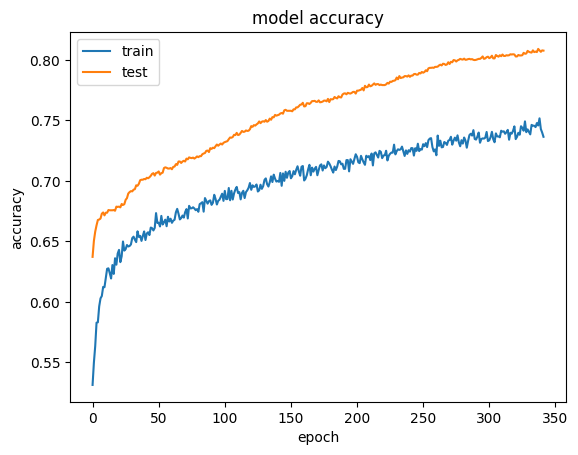

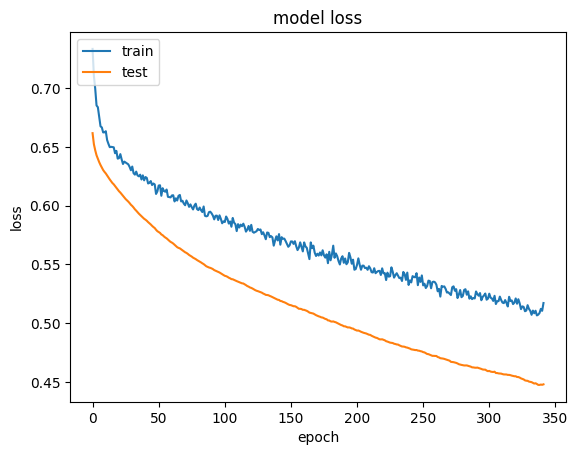

In [2]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()